# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import matplotlib as mpl
import string
import matplotlib.ticker as mticker
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from classes import ExperimentTypes

warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

In [2]:
VARIABLE_INFO = constants.VARIABLE_INFO
VARIABLE_INFO

{'tas': {'longname': 'Near-surface air temperature', 'units': '$^{\\circ}C$'},
 'pr': {'longname': 'Precipitation', 'units': 'mm\\year'},
 'netTOA': {'longname': 'Net TOA flux'},
 'sic': {'longname': 'Sea Ice Area Fraction', 'units': 'fraction'},
 'psl': {'longname': 'Sea level pressure'},
 'tos': {'longname': 'Sea surface temperature', 'units': '$^{\\circ}C$'},
 'surf': {'longname': 'Neat Ocean Heat Uptake'}}

In [3]:
notebook_number='03'
variable = 'tos'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tos/regrid_retimestamped'

In [4]:
longname = VARIABLE_INFO[variable]['longname']
longname

'Sea surface temperature'

In [5]:
units = VARIABLE_INFO[variable]['units']
units

'$^{\\circ}C$'

# Loading Data

In [6]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [7]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.ABRUPT4X,
                                                           models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.CONTROL,
                                                           models_to_get)
utils.pprint_list(files_to_open_experiment, num_start_items=5)

lenght = 7
 0. tos_ann_CCSM3_abrupt4x_2130_g025.nc
 1. tos_ann_CESM104_abrupt4x_5900_g025.nc
 2. tos_ann_CNRMCM61_abrupt4x_1850_g025.nc
 3. tos_ann_HadCM3L_abrupt4x_1000_g025.nc
 4. tos_ann_IPSLCM5A_abrupt4x_1000_g025.nc


In [8]:
reload(constants)

<module 'constants' from '/home/563/ab2313/Documents/PhD/constants.py'>

In [9]:
mask = None#'land'

control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR, mask=mask)
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR, mask=mask)
abrupt4x_ds

Removing first 10 steps for tos_ann_CCSM3_control_1530_g025.nc
Removing first 10 steps for tos_ann_IPSLCM5A_abrupt4x_1000_g025.nc


<xarray.Dataset>
Dimensions:   (time: 1200, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    depth     float64 0.0
Data variables:
    ccsm3     (time, lat, lon) float32 nan nan nan ... -0.3052 -0.306 -0.3073
    cesm104   (time, lat, lon) float32 nan nan nan ... -0.8948 -0.8953 -0.8957
    cnrmcm61  (time, lat, lon) float32 nan nan nan nan ... 5.154 5.152 5.139
    hadcm3l   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ipslcm5a  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mpiesm11  (time, lat, lon) float32 nan nan nan nan ... 2.307 2.314 2.321
    mpiesm12  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Jul 08 03:36:56 2016: cdo remapbil,mygrid tos_CCSM3_abr...
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...
    length:       2120

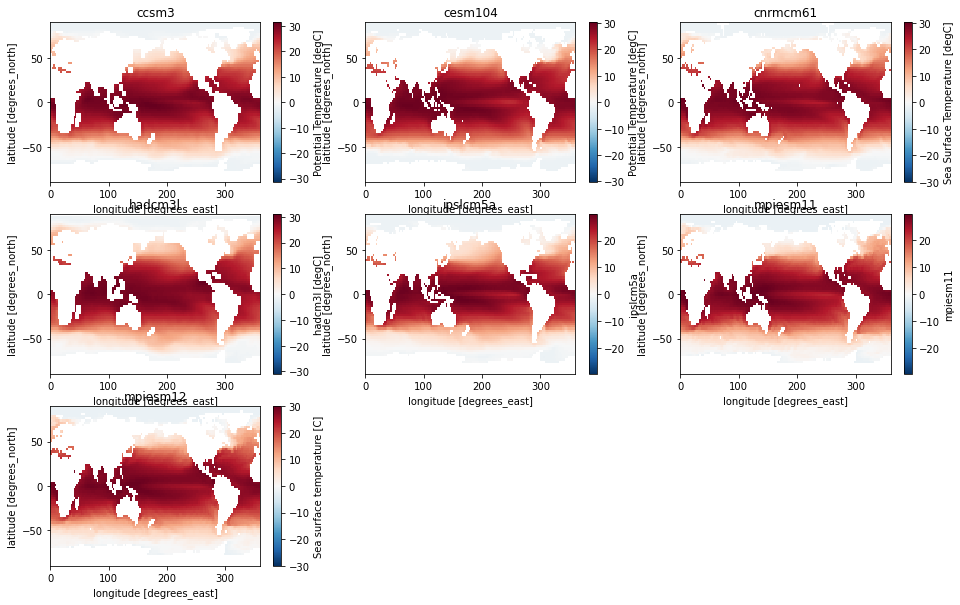

In [10]:
models = list(abrupt4x_ds.data_vars)
num_cols = 3
num_rows = int(np.ceil(len(models)/num_cols))

fig = plt.figure(figsize=(16,10))

for i,model in enumerate(models):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    abrupt4x_ds[model].isel(time=0).plot(ax=ax)
    ax.set_title(model)
    
    ax.set_title(model)

In [11]:
HEMISPHERE_LAT = {'northern_hemisphere': (0,90), 'southern_hemisphere': (-90,0), 'global': (None, None)}

In [12]:
hemisphere = 'global'
HEMISPHERE_LAT[hemisphere]

(None, None)

In [13]:
abrupt4x_mean,control_ds_mean = sn.calculate_global_value(abrupt4x_ds, control_ds, variable)

ccsm3, cesm104, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

In [14]:
RUN_PARAMS = dict(end_window = 370)# 370 is standard
RUN_PARAMS['end_window']

370

In [15]:
%%time
stable_sn_ds, unstable_sn_ds = abrupt4x_mean.sn_ds.sn_multiwindow(
    control_ds_mean, end_window=RUN_PARAMS['end_window'], step_window=2, parallel=True)

ccsm3
20, 26, 32, 44, 50, 38, 62, 56, 68, 74, 80, 86, 104, 92, 98, 110, 22, 58, 64, 100, 106, 112, 28, 40, 46, 34, 70, 52, 82, 76, 88, 94, 24, 66, 60, 108, 102, 114, 30, 42, 36, 48, 54, 72, 78, 84, 90, 96, 116, 122, 128, 134, 140, 146, 118, 152, 158, 170, 164, 124, 182, 176, 130, 188, 200, 194, 136, 206, 142, 148, 120, 126, 132, 138, 144, 160, 154, 150, 172, 166, 178, 184, 208, 190, 196, 202, 212, 218, 224, 236, 230, 242, 156, 162, 174, 168, 180, 186, 198, 192, 204, 210, 214, 226, 220, 238, 232, 244, 248, 254, 260, 266, 272, 278, 284, 302, 290, 296, 216, 228, 222, 234, 240, 246, 250, 256, 268, 262, 274, 280, 286, 298, 304, 292, 308, 314, 320, 332, 326, 338, 252, 258, 270, 264, 276, 282, 288, 300, 294, 306, 310, 316, 322, 334, 344, 328, 350, 340, 356, 362, 368, 352, 346, 364, 358, 312, 318, 324, 354, 348, 336, 330, 360, 366, 342, 68, 62, 32, 20, 44, 38, 26, 50, 80, 56, 74, 86, 92, 98, 104, 110, 58, 82, 100, 40, 76, 46, 28, 88, 94, 22, 52, 64, 106, 34, 70, 112, 60, 78, 84, 90, 96, 108, 1

20, 32, 26, 56, 38, 50, 104, 98, 110, 62, 92, 68, 86, 74, 80, 44, 28, 30, 116, 118, 120, 34, 112, 94, 106, 100, 82, 122, 22, 40, 46, 76, 52, 88, 64, 58, 70, 36, 114, 102, 108, 96, 84, 128, 140, 146, 134, 158, 152, 124, 24, 48, 42, 78, 54, 66, 72, 60, 90, 130, 142, 136, 148, 160, 154, 126, 164, 176, 182, 170, 132, 188, 150, 194, 206, 144, 138, 162, 200, 156, 212, 218, 230, 224, 236, 242, 248, 254, 178, 184, 166, 172, 196, 214, 202, 190, 208, 220, 226, 232, 238, 244, 250, 256, 168, 174, 186, 180, 204, 222, 216, 198, 192, 228, 210, 234, 240, 246, 252, 260, 266, 272, 278, 284, 290, 258, 296, 308, 302, 314, 326, 320, 332, 338, 262, 344, 268, 274, 280, 286, 292, 264, 270, 276, 282, 288, 294, 310, 298, 304, 316, 350, 322, 328, 340, 346, 334, 356, 362, 368, 358, 364, 360, 366, 300, 312, 306, 352, 318, 336, 342, 324, 348, 330, 354, 20, 50, 56, 26, 80, 68, 86, 74, 32, 104, 110, 44, 92, 38, 98, 62, 82, 28, 34, 30, 84, 36, 122, 116, 128, 22, 118, 124, 130, 64, 46, 40, 88, 112, 70, 76, 58, 52, 100,

In [16]:
number_models_present = sn.count_over_data_vars(abrupt4x_mean, list(unstable_sn_ds.data_vars), dim='model')

unstable_number_da = sn.number_finite(unstable_sn_ds)
stable_number_da = sn.number_finite(stable_sn_ds)

unstable_number_da

<xarray.DataArray (window: 175, time: 1182)>
array([[0, 7, 7, ..., 0, 0, 0],
       [0, 7, 7, ..., 0, 0, 0],
       [0, 7, 7, ..., 0, 0, 0],
       ...,
       [0, 7, 7, ..., 0, 0, 0],
       [0, 7, 7, ..., 0, 0, 0],
       [0, 7, 7, ..., 0, 0, 0]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1182-12-31 00:00:00
    depth    float64 0.0
  * window   (window) int64 20 22 24 26 28 30 32 ... 356 358 360 362 364 366 368

# Plots

### Mean Temp Plots

In [17]:
hemisphere_title = string.capwords(hemisphere.replace('_', ' '))
hemisphere_title

'Global'

In [18]:
mask_title = f'({mask} only)' if mask else ''
mask_title

''

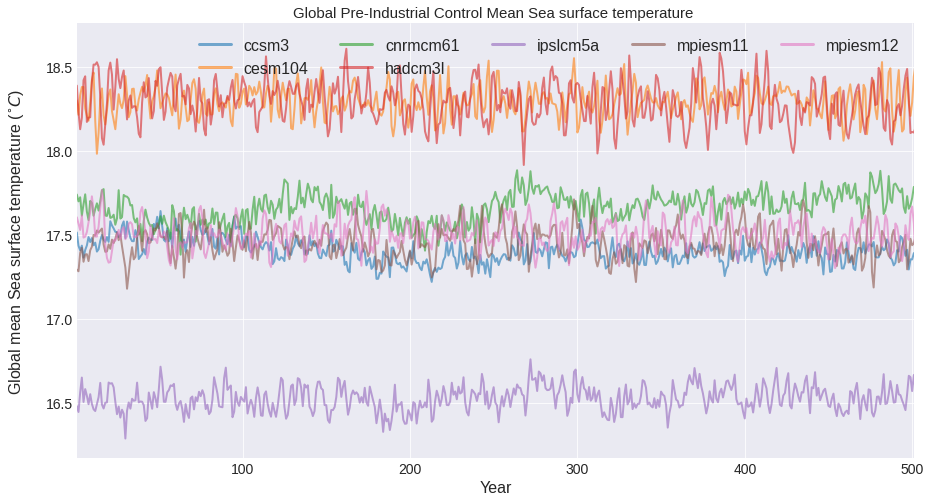

In [19]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for var in list(control_ds_mean.data_vars):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean[var].values, label=var, **plot_kwargs) #  - 273.15
    
ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'{hemisphere_title} Pre-Industrial Control Mean {longname} {mask_title}', fontsize=15);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                         f'{notebook_number}_{variable}_{hemisphere}_mask_{mask}_make_multi_model_control_good_models_t500_year_axis.png'), 
            bbox_inches='tight')

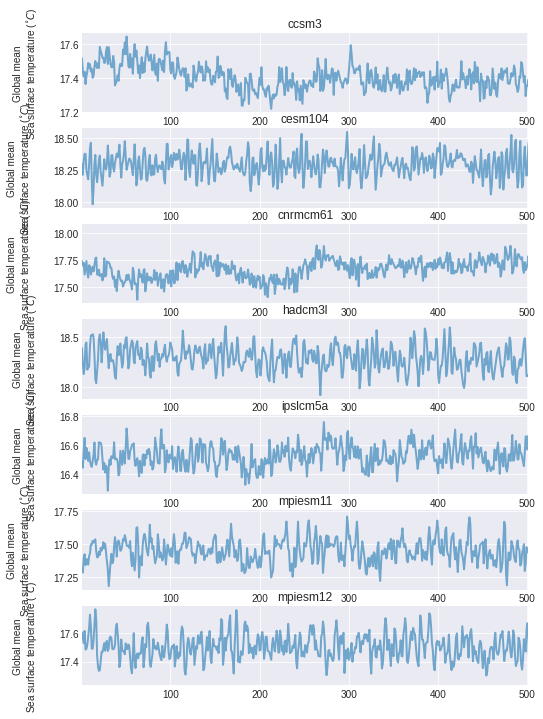

In [20]:

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(8,12))

time = control_ds_mean['time'].values
years = [t.year for t in time]
dvars = list(control_ds_mean.data_vars)
for i,var in enumerate(dvars):
    
    ax = fig.add_subplot(len(dvars), 1, i + 1)

    ax.plot(years, control_ds_mean[var].values, label=var, alpha = 0.6,linewidth = 2)
    ax.set_xlim(years[0], years[500])
#     ax.set_ylim([10, 15])
    ax.set_title(var)

    ax.set_ylabel(f'{hemisphere_title} mean\n{longname} ({units})', labelpad=20)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
        f'{notebook_number}_{variable}_{hemisphere}__mask_{mask}_multi_model_control_good_models_t500_year_axis_split_model.png'), bbox_inches='tight')

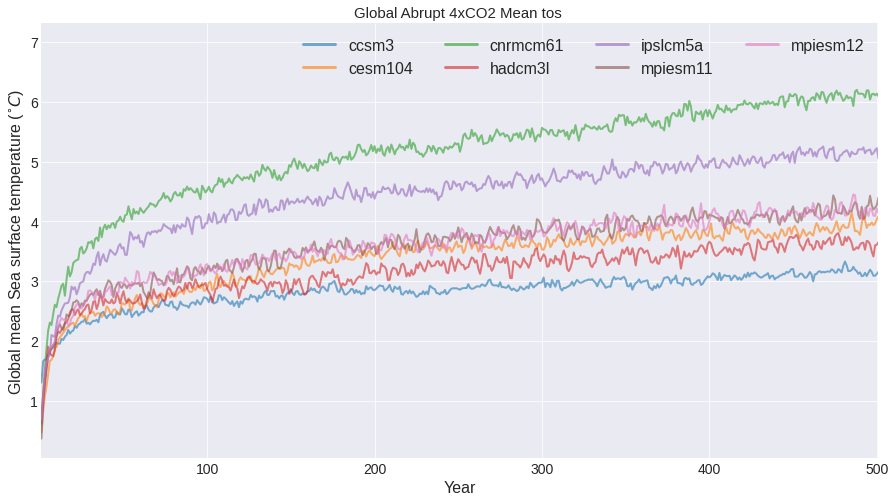

In [21]:
plt.style.use('seaborn-darkgrid')

data = abrupt4x_mean.where(abrupt4x_mean.time.dt.year < 13500, drop = True)

fig, ax = plt.subplots(figsize=(15,8))

for var in list(data.data_vars):
    
    # Removing nans from data
    da = data[var].dropna(dim='time')
    time = da.time.values
    years = [t.year for t in time]

    values = da.values
    
    line_kwargs = dict(alpha = 0.6,linewidth = 2)
    
    ax.plot(years, values, label=var, **line_kwargs)
    c = plt.gca().lines[-1].get_color()
#     ax.annotate(var, xy = (time[-1], values[-1]), color=c, zorder=1000, size=12)

ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16)
ax.set_xlabel('Year', size=16);
ax.set_title(f'{hemisphere_title} Abrupt 4xCO2 Mean {variable} {mask_title}', fontsize=15);

# ax.set_ylim([0,15]);|
ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol=4, fontsize = 16);
[line.set_linewidth(3) for line in leg.get_lines()];
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                         f'{notebook_number}_{variable}_{hemisphere}_mask_{mask}_good_models_mean_t500_year_axis.png'))

### Signal to Noise

In [ ]:
xupperlim = 500
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)

for model in list(unstable_sn_ds.data_vars):
    print(model)
    ECS = constants.MODEL_PARAMS[model.lower()]['ECS']
    title = f'{hemisphere_title} {longname.capitalize()} Signal-to-Noise for {model} (ECS={ECS}K)'
    (fig, ax1, ax2, ax3, cbar) = sn_plot.sn_multi_window_in_time(unstable_sn_ds[model], 
                            stable_sn_ds[model], abrupt4x_mean[model].dropna(dim='time'),
                            title=title, step=1, xupperlim=xupperlim,
                            ax2_ylabel = f'{hemisphere_title} mean\n{longname} ({units})');


    save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{notebook_number}_{variable}_{hemisphere}_mask_{mask}_individual_models_{model}_SN_multi_window.png')
    
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

ccsm3
{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -8, 'vmax': 8, 'step': 1, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fb99a1e36d0>, 'line_color': 'limegreen', 'line_alpha': 0.65, 'ax2_ylabel': 'Global mean\nSea surface temperature ($^{\\circ}C$)', 'cbar_label': 'S/N', 'cbartick_offset': 0, 'title': 'Global Sea surface temperature Signal-to-Noise for ccsm3 (ECS=2.57K)', 'label_size': 12, 'extend': 'both', 'xlowerlim': None, 'xupperlim': 500, 'filter_max': False, 'levels': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), 'cbar_xticklabels': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), 'cbar_ticks': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8])}


data_vars=['variable']
0 Saving /home/563/ab2313/gdata/images/PhD/top_level/03_tos_global_mask_None_individual_models_ccsm3_SN_multi_window.png
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds L

KeyboardInterrupt: 

Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 14611 ticks ([-729950.0, ..., 550.0]), which exceeds Locator.MAXTICKS (1000).


In [22]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plot.sn_multi_window_in_time(
    unstable_number_da, stable_number_da, abrupt4x_mean, 
    logginglevel='DEBUG', 
    hieght = 15, width = 12,
    vmin=0, vmax=7, step=1, cbartick_offset = 0.5,
    cmap='Reds',
    extend='neither', xupperlim = 500,
    cbar_label= 'Number of Unstable Models', 
    ax2_ylabel = f'Global mean {longname} ({units})',
    title = f'{hemisphere_title} Fraction of Models Stable for {longname}', cbar_ncols = 3, filter_max=True)

fig.savefig(
    os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
    f'{notebook_number}_{variable}_{hemisphere}_all_model_SN_multi_window_long_models_number_unstable')
        , dpi=200, bbox_inches='tight')

{'height': 15, 'width': 12, 'hspace': 0.3, 'vmin': 0, 'vmax': 7, 'step': 1, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fba82b40b80>, 'line_color': 'limegreen', 'line_alpha': 0.65, 'ax2_ylabel': 'Global mean Sea surface temperature ($^{\\circ}C$)', 'cbar_label': 'Number of Unstable Models', 'cbartick_offset': 0.5, 'title': 'Global Fraction of Models Stable for Sea surface temperature', 'label_size': 12, 'extend': 'neither', 'xlowerlim': None, 'xupperlim': 500, 'hieght': 15, 'cbar_ncols': 3, 'filter_max': True, 'levels': array([0, 1, 2, 3, 4, 5, 6, 7]), 'cbar_xticklabels': array([0, 1, 2, 3, 4, 5, 6]), 'cbar_ticks': array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])}


ERROR! Session/line number was not unique in database. History logging moved to new session 720
locator: <matplotlib.ticker.FixedLocator object at 0x7fb9a1897d00>
cbar x-tick labels = [0 1 2 3 4 5 6]
data_vars=['ccsm3', 'cesm104', 'cnrmcm61', 'hadcm3l', 'ipslcm5a', 'mpiesm11', 'mpiesm12']
0 1 2 3 4 5 6 Locator


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb9e8eb6040> (for post_execute):


KeyboardInterrupt: 